In [1]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import invgamma
import logging


In [2]:
from notebookutils import root_dir, corr_plot; root_dir()

now in dir:  /Users/Jeppe/Projects/BayesFactorModel


In [3]:
from model.utils import read_clean_kv17, read_testdata1, read_testdata2

In [4]:
testdata1 = read_testdata1()

In [58]:
data = matrix(testdata1) #making testing different data set simple

(2000, 15)


In [6]:
np.random.seed(100)

In [7]:
from functools import wraps

In [8]:
def print_dimension(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        for arg in args:
            try:
                print(arg.shape)
            except:
                pass
        return func(*args, **kwargs)
    return wrapper

@print_dimension
def matrix(x):
    return np.matrix(x)

def vector(array):
    return np.asarray(array).reshape(-1)

### Specifications

In [9]:
class GibbsSampler():
    
    def __init__(self, n_factors, data):
        
        self.y = data
        self.k = n_factors
        self.p = data.shape[1]
        self.T = data.shape[0]
        self.I_k = np.identity(self.k)
        self.I_p = np.identity(self.p)
        
        self.v = 0.5
        self.s_sq = 2
        self.C0 = 2
        self.mu0 = 1
        
        self.Beta_list = list()
        self.Sigma_list = list()
        self.F_list = list()
        
        print('number of variables:', self.p,' number of observations:', self.T)

    def f_t(self, Beta, Sigma, t):
        """Posterior of f_t"""
        
        y_t = self.y[[t]].T
        S_inv = linalg.inv(Sigma*self.I_p)
        
        
        scale = linalg.inv(self.I_k + np.dot(np.dot(Beta.T, S_inv),Beta))
        loc = vector(np.dot(np.dot(np.dot(scale, Beta.T), S_inv), y_t))

        return np.random.multivariate_normal(loc, scale)
    
    def d_i(self, Beta, F, i):
        """Helper method for calculating sigma"""
        
        y_i = self.y.T[[i]]
        Beta_i = Beta[[i]]
        
        tmp = (y_i.T - np.dot(F, Beta_i.T))
        return float(np.dot(tmp.T, tmp))
    
    def sigma_i(self, Beta, F, i):
        d_i = self.d_i(Beta, F, i)
        
        alpha = (self.v + self.T)/2
        scale = (self.v*self.s_sq + d_i)/2
        return invgamma.rvs(alpha,scale = scale)
    
    
    
    def Beta_i(self, Sigma, F, i):
        
        if i < self.k:
            
        
            C_i = self.C_i(F, Sigma, i)
            m_i = self.m_i(C_i, F, Sigma, i)
            
            B_i = np.random.multivariate_normal(m_i, C_i)
            while B_i[i] <= 0:
                print(B_i[i]) # possible bug
                #B_i = np.random.multivariate_normal(m_i, C_i)      
                B_i[i] = 0.1
                
            if i < self.k:
                B_i = np.append(B_i, np.zeros(self.k-i - 1))
        
        elif i >= self.k:
        
            C_k = self.C_k(F, Sigma, i)
            m_k = self.m_k(C_k, F, Sigma, i)
        
            B_i = np.random.multivariate_normal(m_k, C_k)
            
        else:
            raise ValueError('k is {0}, i is {1} - Beta_i probs'.format(self.k , i))
        
        return vector(B_i)
        
    def C_i(self, F, Sigma, i):
        """If i <= k """
        
        F_i = F.T[:i+1].T
        sigma_i = Sigma[i]
        identity_i = np.identity(i+1)

        return linalg.inv((1/self.C0) * identity_i + (1/ sigma_i)*np.dot(F_i.T, F_i))
        
            
    def C_k(self, F, Sigma, i):
        """if i > k"""
        
        sigma_i = Sigma[i]
        return linalg.inv((1/self.C0) * self.I_k + (1/ sigma_i)*np.dot(F.T, F))
    
    def m_i(self, C_i, F, Sigma, i):
        """If i <= k """
        
        F_i = F[:,:i+1] # 2000 X i
        sigma_i = Sigma[i] # 1 x 1
        ones_i = np.matrix(np.ones(i+1)).T
        y_i = self.y[: ,[i]]
        tmp = (1/self.C0)*self.mu0 * ones_i + (1/sigma_i) * np.dot(F_i.T, y_i)
        return vector(np.dot(C_i, tmp))
        
    def m_k(self, C_k, F, Sigma, i):
       
        """if i > k"""
        
        sigma_i = Sigma[i] # 1 x 1
        ones_k = np.matrix(np.ones(self.k)).T
        y_i = self.y[: ,[i]]
        
        tmp = (1/self.C0)*self.mu0 * ones_k + (1/sigma_i) * np.dot(F.T, y_i)
        return vector(np.dot(C_k, tmp))

    def calc_Beta(self):
        
        B = np.matrix([self.Beta_i(self.Sigma, self.F, i) for i in range(self.p)])
        self.Beta_list.append(B)
        return B
    
    def calc_F(self):
        
        F = np.matrix([self.f_t(self.Beta, self.Sigma, t) for t in range(self.T)])
        self.add('F',F)
        return F
    
    def calc_Sigma(self):
        
        Sigma = vector([self.sigma_i(self.Beta, self.F, i) for i in range(self.p)])
        self.add('Sigma', Sigma)
        return Sigma
            
    @property
    def Beta(self):
        return self.Beta_list[-1]
    
    @property
    def F(self):
        return self.F_list[-1]
    
    @property
    def Sigma(self):
        return self.Sigma_list[-1]
    
    
    def add(self,param, value):
        """ add to Sigma_list, Beta_list or F_list
        
        Parameters
        ==========
        param: (str)
            string that should be of {'Sigma', 'F', 'Beta'}
        value: (obj)
            appropriate object for given list
        
        """
        
        if param == 'Sigma':
            self.Sigma_list.append(value)
            
        elif param == 'F':
            self.F_list.append(value)
            
        elif param == 'Beta':
            self.Beta_list.append(value)
            
        else:
            raise ValueError("Param must be in {'F', 'Sigma', 'Beta'}")
               
    def sampler(self, n_iterations):
        
        for i in range(n_iterations):
            
            print(i)
            self.calc_F()
            self.calc_Sigma()
            self.calc_Beta()
        
        
    

In [10]:
sigma_array = np.array([np.random.normal()**2 for _ in range(15)])
F = np.matrix([np.random.normal(size=3) for _ in range(2000)])
Beta = np.matrix(np.random.normal(size=(15,3)))

In [11]:
gs = GibbsSampler(n_factors=3, data=data)
gs.add('Sigma',sigma_array)
gs.add('F', F)
gs.add('Beta',Beta)

number of variables: 15  number of observations: 2000


In [12]:
gs.sampler(100)

-0.043857676321557695
-0.25603489268422475
-0.5478286526970726
-0.5479052616822033
-0.5510882852195375
-0.5466974911446231
-0.5654590395206247
-0.461099188094306
-0.484693148920302
-0.4527570392751699
-0.5675662167832023
-0.5893688079754689
-0.5281982088988608
-0.4701460835245404
-0.554614002471543
-0.5721687522948231
-0.5036450965872403
-0.598567665574212
-0.46680777840944254
-0.45457145352703576
-0.594192880483704
-0.4441052262552911
-0.4589816004509553
-0.465182195883989
-0.4374873028158624
-0.41876981943103797
-0.3004884217308938
-0.39543721872832116
-0.489483438843093
-0.469150481455065
-0.4884054298473003
-0.6281234170926221
-0.5688162155757684
-0.45474836821783626
-0.4212777909625997
-0.4721923444630199
-0.45413925053949256
-0.4377061022482513
-0.3820475912657494
-0.3672054512341755
-0.3579192929287681
-0.41476553437311253
-0.3402736176517639
-0.3204883046024728
-0.4368994717788721
-0.4552671910509306
-0.372742127849612
-0.34133625600056583
-0.3998733528174383
-0.460923452402739

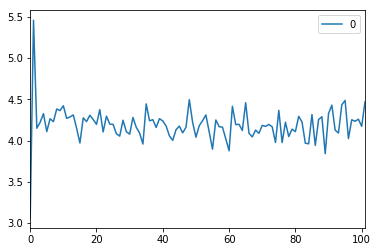

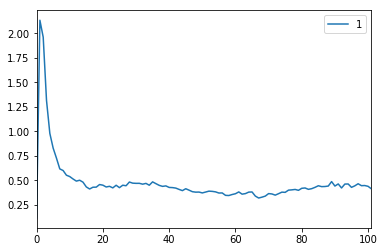

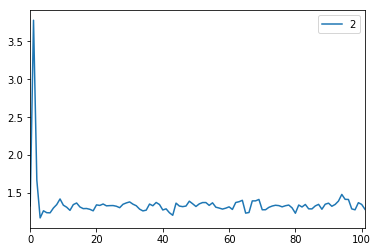

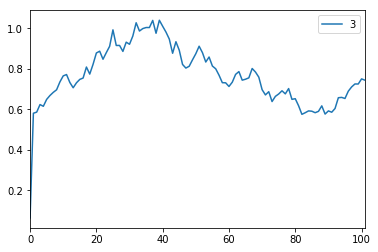

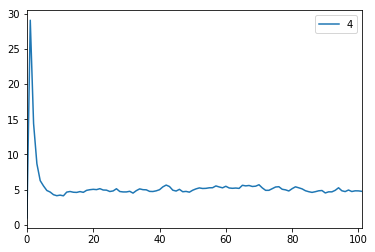

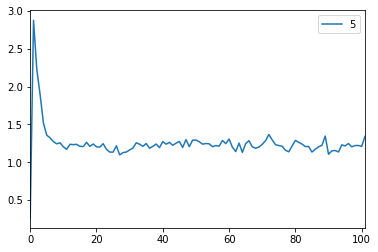

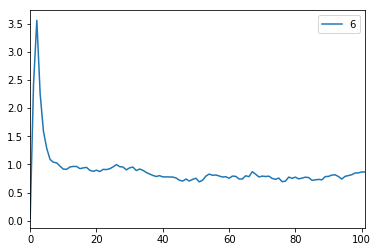

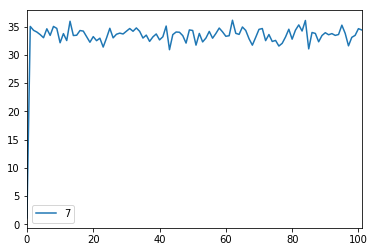

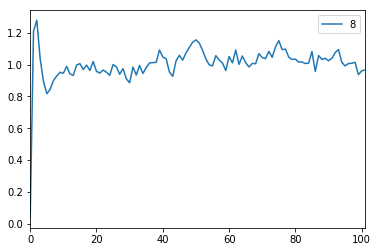

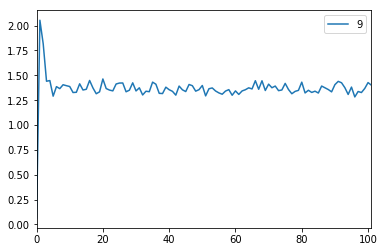

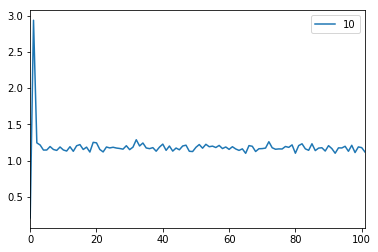

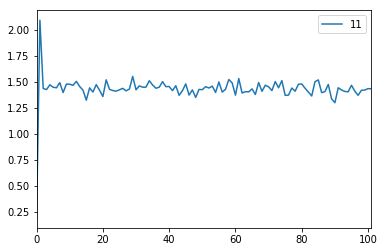

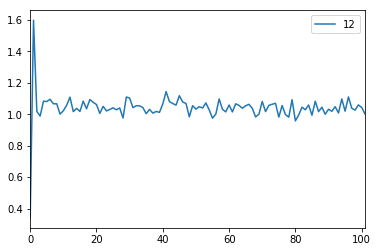

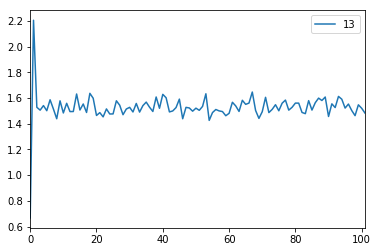

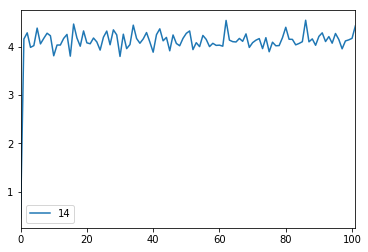

In [28]:
#for sigma in gs.Sigma_list
    
a = pd.DataFrame(gs.Sigma_list)

for i in range(15):
    a.plot(x=a.index, y =i)


In [53]:
k = [np.squeeze(np.asarray(beta[:,[1]])) for beta in gs.Beta_list]

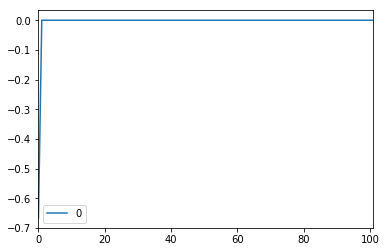

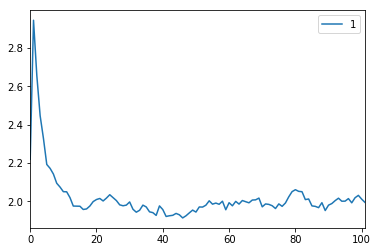

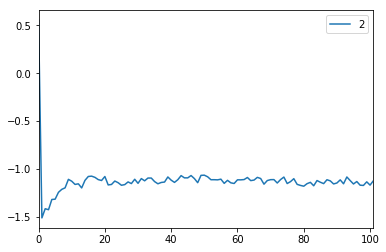

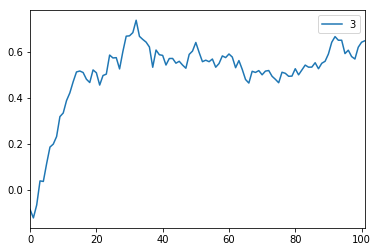

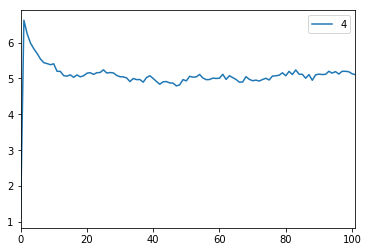

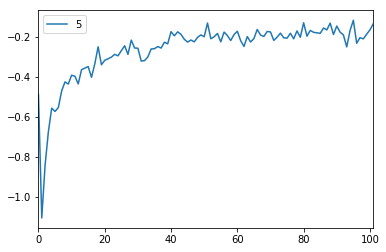

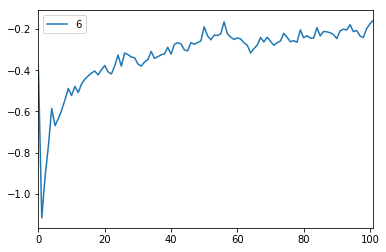

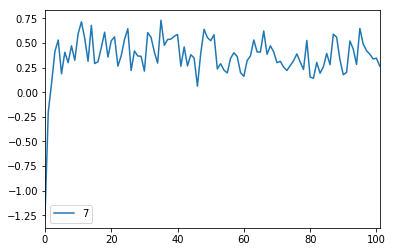

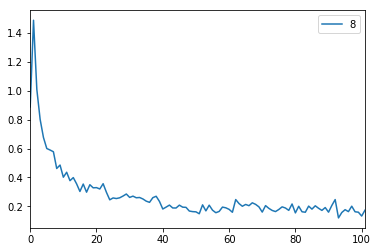

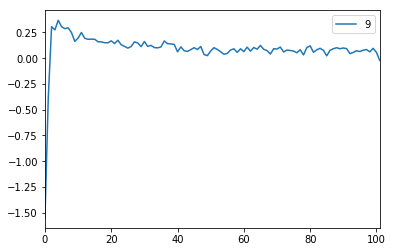

In [54]:
b = pd.DataFrame(k)

for i in range(10):
    b.plot(x=b.index, y=i)

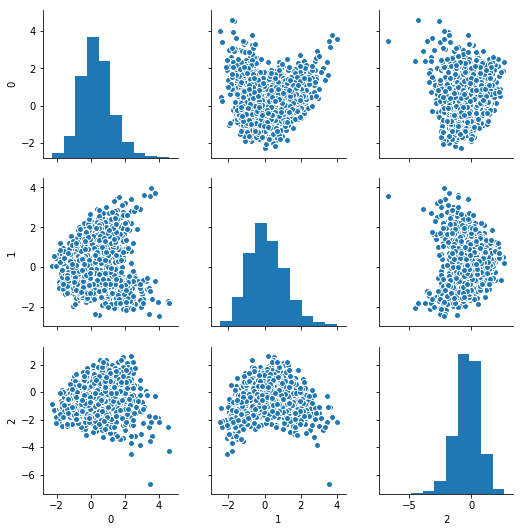

In [57]:
sbn.pairplot(pd.DataFrame(gs.F))